# <신장 종양 적출에 따른 손실체적(RAIV) 예측>

신장 종양 평가지표(PADUA, Renal..)를 활용한 최소한의 필요한 종양 적출 체적 예측 <br>
과거에는 신장에 발생한 악성종양을 제거할 때 한쪽 신장을 모두 제거하는 것이 문제가 없는 것으로 인식됐었으나, 최근에는 신장 한쪽을 제거한 경우 수술 후 신부전·심혈관질환 각종 대사성 질환의 빈도가 증가한다는 보고가 있어 가능하면 신장을 보존하는 것이 추천되는 경향
신장은 출혈 위험이 크며, 생명 유지에 중요한 기능을 하는 장기이므로 신장의 기능을 보존할 수 있게 신장 수술의 목표는 최소 절개 및 최대 보존
신장을 최대한 보존해 합병증을 줄임으로써 중요한 만성질환 예방과 삶의 질을 높여 환자들에게 큰 도움이 될 것

### data

- T_surface_loc : 종양의 표면 위치 <br>
- T_sinus_dt : 종양의 신동과의 거리 <br>
- T_height_loc : 종양의 세로 기준 위치 <br>
- T_gm_over : 종양의 사구체 침범 정도 <br>
- T_size : 종양의 크기 <br>
- T_Exophytic : 외성장비율 <br>
- T_near_urethra : 종양과 요도의 근접 정도 <br>
- T_rel_urethra : 종양의 요도 기준 상대 위치 <br>
- T_APX : 종양의 위치 - 전/후방(숫자) <br>

- 'serial' : 환자번호
- 'RAIV_1' : 손실체적(cm^3)


# 1. 데이터 불러오기

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [75]:
padua = pd.read_csv('/content/drive/MyDrive/zerobase/MLproject/kideny_PADUA_upload.csv')
renal = pd.read_csv('/content/drive/MyDrive/zerobase/MLproject/kideny_RENAL_upload.csv')
treat = pd.read_csv('/content/drive/MyDrive/zerobase/MLproject/kidney_treat_upload.csv')

In [76]:
padua.head()

,serial,Tumor_PADUA,Exophytic_PADUA,Rim_PADUA,Sinus_PADUA,Polarlocation_PADUA,Collectingsystem_PADUA,PADUA_total
0,1,2.0,1.0,2.0,1.0,1.0,1.0,8
1,2,1.0,2.0,1.0,1.0,2.0,1.0,8
2,3,1.0,1.0,1.0,1.0,2.0,1.0,7
3,4,1.0,1.0,1.0,1.0,2.0,2.0,8
4,5,1.0,2.0,1.0,1.0,2.0,1.0,8


In [77]:
renal.head()

,serial,Radius_RENAL,Exophytic_RENAL,Nearness_RENAL,APX_RENAL,Location_RENAL,RENAL_total
0,1,2.0,1.0,1.0,2.0,1.0,4
1,2,1.0,2.0,2.0,2.0,2.0,5
2,3,1.0,1.0,1.0,1.0,1.0,3
3,4,1.0,1.0,3.0,2.0,3.0,5
4,5,1.0,2.0,1.0,1.0,3.0,4


In [78]:
treat.head()

,serial,RAIV_1
0,1,51.1
1,2,46.1
2,3,14.8
3,4,19.7
4,5,14.8


# 2. 데이터 정리
중복 컬럼 삭제(종양의 크기, 외성장 비율) 및 데이터 합치기

In [83]:
merged_data = pd.merge(padua, renal, on='serial')
# padua 에서 중복 컬럼 삭제
merged_data = merged_data.drop(['Tumor_PADUA', 'Exophytic_PADUA'], axis=1)
# treat 데이터 merge
merged_result = pd.merge(merged_data, treat, on='serial', how='left')
# serial을 인덱스로 설정
merged_result.set_index('serial', inplace=True)

In [84]:
merged_result

,Rim_PADUA,Sinus_PADUA,Polarlocation_PADUA,Collectingsystem_PADUA,PADUA_total,Radius_RENAL,Exophytic_RENAL,Nearness_RENAL,APX_RENAL,Location_RENAL,RENAL_total,RAIV_1
serial,,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,8,2.0,1.0,1.0,2.0,1.0,4,51.1
2,1.0,1.0,2.0,1.0,8,1.0,2.0,2.0,2.0,2.0,5,46.1
3,1.0,1.0,2.0,1.0,7,1.0,1.0,1.0,1.0,1.0,3,14.8
4,1.0,1.0,2.0,2.0,8,1.0,1.0,3.0,2.0,3.0,5,19.7
5,1.0,1.0,2.0,1.0,8,1.0,2.0,1.0,1.0,3.0,4,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,1.0,2.0,1.0,8,1.0,2.0,1.0,1.0,3.0,4,21.3
409,1.0,1.0,2.0,1.0,8,1.0,2.0,1.0,1.0,3.0,4,30.5
410,1.0,1.0,1.0,1.0,7,1.0,2.0,1.0,1.0,1.0,4,70.7


- 컬럼명 변경 , 순서 재정렬

In [85]:
# RAIV_1 -> RAIV
merged_result = merged_result.rename(columns={'Radius_RENAL': 'T_size', 'Exophytic_RENAL':'T_Exophytic',
                            'Rim_PADUA':'T_surface_loc','Polarlocation_PADUA':'T_height_loc',
                            'Collectingsystem_PADUA':'T_gm_over','Sinus_PADUA':'T_sinus_dt',
                            'Nearness_RENAL':'T_near_urethra','APX_RENAL':'T_APX','Location_RENAL':'T_rel_urethra','RAIV_1': 'RAIV'
                            })
merged_result = merged_result[['T_surface_loc', 'T_sinus_dt', 'T_height_loc', 'T_gm_over', 'T_size', 'T_Exophytic', 'T_near_urethra', 'T_rel_urethra', 'T_APX', 'PADUA_total', 'RENAL_total', 'RAIV']]
merged_result

,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,T_size,T_Exophytic,T_near_urethra,T_rel_urethra,T_APX,PADUA_total,RENAL_total,RAIV
serial,,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,8,4,51.1
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,8,5,46.1
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,7,3,14.8
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,8,5,19.7
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,8,4,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,8,4,21.3
409,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,8,4,30.5
410,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,7,4,70.7


- PADUA_total , RENAL_total 삭제
- 하나의 total 점수생성

In [86]:
merged_result['Total'] = merged_result[['T_surface_loc', 'T_sinus_dt', 'T_height_loc', 'T_gm_over', 'T_size', 'T_Exophytic', 'T_near_urethra', 'T_rel_urethra', 'T_APX']].sum(axis=1)
merged_result.drop(columns=['PADUA_total', 'RENAL_total'], inplace=True)

merged_result.head()

,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,T_size,T_Exophytic,T_near_urethra,T_rel_urethra,T_APX,RAIV,Total
serial,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,51.1,12.0
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,46.1,14.0
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,14.8,10.0
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,19.7,16.0
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,14.8,13.0


결측치 삭제

In [87]:
merged_result = merged_result.dropna()
merged_result

,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,T_size,T_Exophytic,T_near_urethra,T_rel_urethra,T_APX,RAIV,Total
serial,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,51.1,12.0
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,46.1,14.0
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,14.8,10.0
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,19.7,16.0
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,14.8,13.0
...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,21.3,13.0
409,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,30.5,13.0
410,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,70.7,10.0


In [88]:
# 새로운 컬럼(T_size + T_Exophytic = T_size_exo )
merged_result['T_size_exo'] = merged_result['T_size'] + merged_result['T_Exophytic']

<ipython-input-88-69f7e9aeedac>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [89]:
merged_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 1 to 412
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   T_surface_loc   389 non-null    float64
 1   T_sinus_dt      389 non-null    float64
 2   T_height_loc    389 non-null    float64
 3   T_gm_over       389 non-null    float64
 4   T_size          389 non-null    float64
 5   T_Exophytic     389 non-null    float64
 6   T_near_urethra  389 non-null    float64
 7   T_rel_urethra   389 non-null    float64
 8   T_APX           389 non-null    float64
 9   RAIV            389 non-null    float64
 10  Total           389 non-null    float64
 11  T_size_exo      389 non-null    float64
dtypes: float64(12)
memory usage: 39.5 KB


# 3. 데이터 탐색(EDA)

In [90]:
merged_result.head()

,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,T_size,T_Exophytic,T_near_urethra,T_rel_urethra,T_APX,RAIV,Total,T_size_exo
serial,,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,51.1,12.0,3.0
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,46.1,14.0,3.0
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,14.8,10.0,2.0
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,19.7,16.0,2.0
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,14.8,13.0,3.0


- 각 변수들의 분포도 시각화

In [93]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create a grid of subplots, 3 columns wide
fig = make_subplots(rows=4, cols=3, subplot_titles=merged_result.columns)

# Iterate through each variable and create a histogram for it
for i, col in enumerate(merged_result.columns):
    hist_trace = go.Histogram(x=merged_result[col])
    fig.add_trace(hist_trace, row=i // 3 + 1, col=i % 3 + 1)

# Update layout
fig.update_layout(height=600, width=900, title_text="Histograms of Variables")

# Show plot
fig.show()


# 규리
# # 분포확인( 범주형 데이터 )
# merged_corr = merged_result.drop(['serial'], axis=1)
# merged_corr.hist(bins=10, figsize=(15,10))
# plt.show()


상관관계

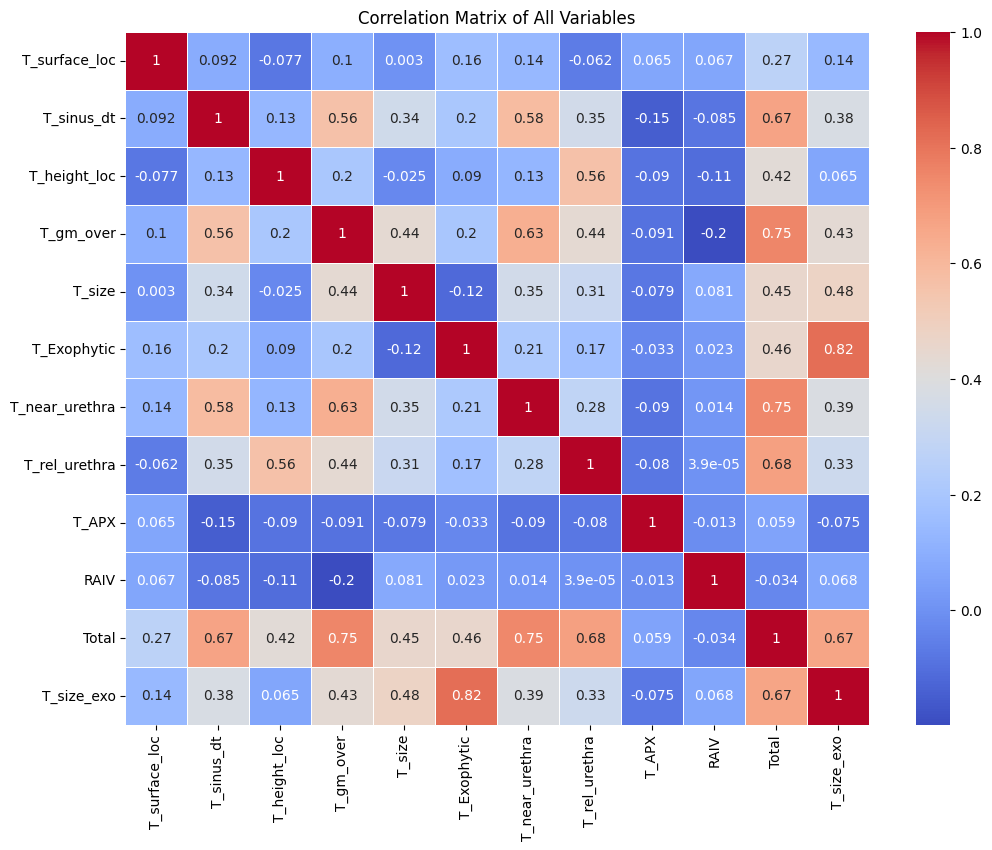

In [94]:


import matplotlib.pyplot as plt
import seaborn as sns

# Get all numeric columns
numeric_columns = merged_result.select_dtypes(include=['int64', 'float64']).columns

# Create a correlation matrix
correlation_matrix = merged_result[numeric_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, cmap="coolwarm")
plt.title("Correlation Matrix of All Variables")
plt.show()


boxplot

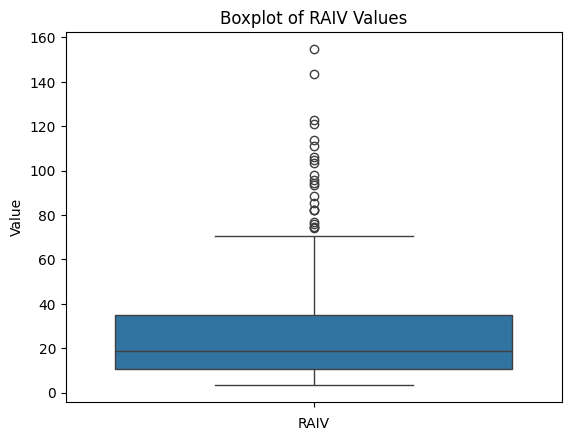

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot of the RAIV_1 variable
sns.boxplot(data=merged_result, y="RAIV")

# Add a title and labels
plt.title("Boxplot of RAIV Values")
plt.xlabel("RAIV")
plt.ylabel("Value")

# Show the plot
plt.show()


x축에는 전체데이터의 RAIV, y축은 Total <br>
이상치와 아닌 데이터의 total 점수를 비교해 보고 싶었음

In [98]:
import plotly.graph_objs as go

# Filter merged_result based on RAIV_1 >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV_1 < 80
trace_raiv_lt_80 = go.Scatter(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['Total'],
    mode='markers',
    name='RAIV < 80'
)

# Create a scatter plot for RAIV_1 >= 80
trace_raiv_gte_80 = go.Scatter(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['Total'],
    mode='markers',
    name='RAIV >= 80'
)

# Create layout
layout = go.Layout(
    title="Scatter Plot of Total Scores vs RAIV",
    xaxis=dict(title='RAIV'),
    yaxis=dict(title='Total')
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()


T_Exophytic , RAIV_1 을 2차원으로 확인

In [99]:
import plotly.graph_objs as go

# Filter merged_result based on RAIV >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV < 80
trace_raiv_lt_80 = go.Scatter(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['T_Exophytic'],
    mode='markers',
    name='RAIV < 80'
)

# Create a scatter plot for RAIV >= 80
trace_raiv_gte_80 = go.Scatter(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['T_Exophytic'],
    mode='markers',
    name='RAIV >= 80'
)

# Create layout
layout = go.Layout(
    title="Scatter Plot of T_Exophytic vs RAIV",
    xaxis=dict(title='RAIV'),
    yaxis=dict(title='T_Exophytic')
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()


T_size, T_Exophytic , RAIV_1 을 3차원으로 확인

In [100]:
import plotly.graph_objs as go

# Filter merged_result based on RAIV >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV < 80
trace_raiv_lt_80 = go.Scatter3d(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['T_Exophytic'],
    z=merged_result[merged_result['RAIV'] < 80]['T_size'],
    mode='markers',
    name='RAIV < 80',
    marker=dict(size=5)
)

# Create a scatter plot for RAIV >= 80
trace_raiv_gte_80 = go.Scatter3d(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['T_Exophytic'],
    z=merged_result_raiv_80['T_size'],
    mode='markers',
    name='RAIV >= 80',
    marker=dict(size=5)
)

# Create layout
layout = go.Layout(
    title="3D Scatter Plot of T_Exophytic and T_size vs RAIV",
    scene=dict(
        xaxis=dict(title='RAIV'),
        yaxis=dict(title='T_Exophytic'),
        zaxis=dict(title='T_size')
    )
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()


**결론: T_size는 RAIV값에 큰 영향을 끼치는 것 같지가 않다.**

T_near_urethra , T_Exophytic , RAIV 값을 3차원으로 확인

In [101]:
import plotly.graph_objs as go

# Filter merged_result based on RAIV >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV < 80
trace_raiv_lt_80 = go.Scatter3d(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['T_Exophytic'],
    z=merged_result[merged_result['RAIV'] < 80]['T_near_urethra'],
    mode='markers',
    name='RAIV < 80',
    marker=dict(size=5)
)

# Create a scatter plot for RAIV >= 80
trace_raiv_gte_80 = go.Scatter3d(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['T_Exophytic'],
    z=merged_result_raiv_80['T_near_urethra'],
    mode='markers',
    name='RAIV >= 80',
    marker=dict(size=5)
)

# Create layout
layout = go.Layout(
    title="3D Scatter Plot of T_Exophytic and T_near_urethra vs RAIV",
    scene=dict(
        xaxis=dict(title='RAIV'),
        yaxis=dict(title='T_Exophytic'),
        zaxis=dict(title='T_near_urethra')
    )
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()


**결론: 오히려 T_size 보다 T_near_urethra 가 유의미한 데이터로 보임**


### 이상치제거X : merged_result 사용 / 단, 원본은 남겨두고 merged_copy라는 변수로 사용하길 권장 (v1버전)
### 이상치제거O : merged_data_80이라는 변수를 제거한 merged_drop 을 사용하세요 (아래에 생성해둠) (v2버전)


RAIV가 80이상인 데이터 따로 변수에 할당해줌

In [102]:
merged_data_80 = merged_result[merged_result['RAIV'] > 80]
merged_data_80

,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,T_size,T_Exophytic,T_near_urethra,T_rel_urethra,T_APX,RAIV,Total,T_size_exo
serial,,,,,,,,,,,,
11,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,95.7,11.0,2.0
16,1.0,2.0,1.0,1.0,1.0,2.0,3.0,1.0,2.0,85.4,14.0,3.0
19,2.0,1.0,2.0,1.0,1.0,3.0,1.0,2.0,2.0,114.0,15.0,4.0
22,1.0,2.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0,154.8,14.0,4.0
46,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,94.2,10.0,3.0
50,1.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0,1.0,111.3,13.0,4.0
53,2.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,2.0,103.6,14.0,4.0
60,1.0,1.0,2.0,1.0,1.0,3.0,1.0,3.0,1.0,143.4,14.0,4.0
79,1.0,1.0,2.0,1.0,1.0,2.0,3.0,2.0,2.0,93.6,15.0,3.0


RAIV80이상인 데이터없는 데이터 새로 만들어줌
(merged_data는 살려둠)

# 2. v2 데이터 (이상치제거O)

In [103]:
#이상치 제거버전
merged_drop = merged_data.drop(merged_data_80.index)
merged_drop.info()

,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,T_size,T_Exophytic,T_near_urethra,T_rel_urethra,T_APX,RAIV,Total,T_size_exo
serial,,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,51.1,12.0,3.0
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,46.1,14.0,3.0
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,14.8,10.0,2.0
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,19.7,16.0,2.0
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,14.8,13.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,21.3,13.0,3.0
409,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,30.5,13.0,3.0
410,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,70.7,10.0,3.0


# 04. 데이터 나누기(train_test_split)